# Geoprocessing

In [41]:
!apt install python3-rtree

'apt' is not recognized as an internal or external command,
operable program or batch file.


In [42]:
!pip install geopandas

In [43]:
import geopandas as gpd
import pandas as pd
import requests
import zipfile
import matplotlib.pyplot as plt

First let's import some data taken at the census tract level.

In [44]:
# # Load files from working directory (be sure to download data and place it in directory)
# # unzip the file
# with zipfile.ZipFile('MD_DC_VA.zip') as myzip:
#     myzip.extractall()

In [45]:
tracts = gpd.read_file("tl_2019_01001_roads.shp")

In [46]:
tracts.shape

(2677, 5)

In [47]:
tracts.head()

,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,1103672784948,McGee Rd Exn,M,S1400,"LINESTRING (-86.68571 32.60424, -86.68572 32.6..."
1,1103677525952,Buena Vis Lp,M,S1400,"LINESTRING (-86.44949 32.42550, -86.44939 32.4..."
2,110585093535,Alt Rte Route Co Rd 40 W,O,S1400,"LINESTRING (-86.41336 32.58936, -86.41279 32.5..."
3,110585093547,Alt Rte Route County Road 40 W,O,S1400,"LINESTRING (-86.63839 32.53354, -86.63826 32.5..."
4,110585093548,Alt Rte Route County Road 121,O,S1400,"LINESTRING (-86.42795 32.64767, -86.42786 32.6..."


In [48]:
tracts.crs

In [49]:
tracts.set_index("LINEARID", inplace=True)

In [50]:
tracts.columns

Index(['FULLNAME', 'RTTYP', 'MTFCC', 'geometry'], dtype='object')

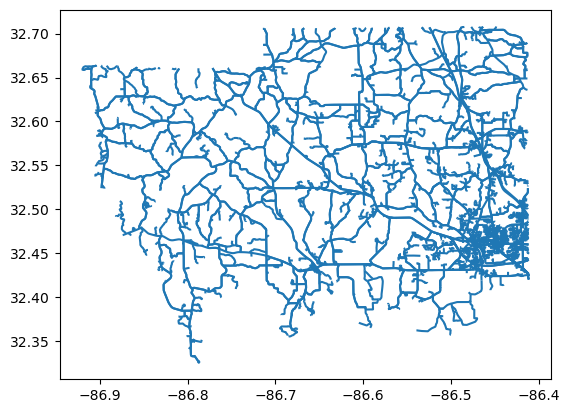

In [51]:
tracts.plot();

## Changing our unit of Analysis
We can easily use the `.dissolve()` function to aggregate our information "up" and change our observations, and thus our unit of analysis, to states rather than tracts. This function is like panda's `groupby` in that it allows you to perform an aggregation function on the rest of the columns in the data, such as `sum`, `max`, `avg`. You can read more about it [here](http://geopandas.org/aggregation_with_dissolve.html). 

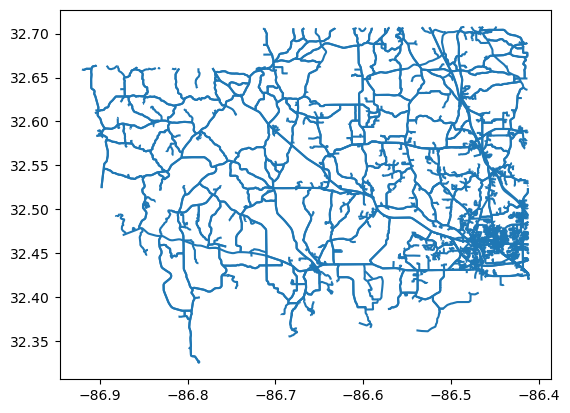

In [52]:
states = tracts[~tracts.FULLNAME.isnull()] #~ indicates opposite of resulting T/F values
states.plot();

In [53]:
# %time states = states.dissolve(by='STATE_FIPS', aggfunc='sum')

Now, we have one observation for each state, and the value of each variable is the `sum` of all the tract values in each state. Note that we used `%time` cell magic above to report how long that command took.

KeyError: 'AREANAME'

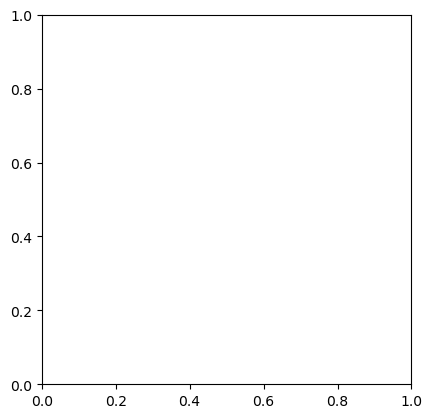

In [54]:
states.plot(column='AREANAME', cmap='rainbow');

### Imagine we want to go back to the tract level.
If we didn't have our `AREANAME` column to join back on, we could use the `.overlay()` method to get the _intersection_ of where DC's geometry overlaps with our census tracts. The below image from the [QGIS docs](https://docs.qgis.org/3.4/en/docs/gentle_gis_introduction/vector_spatial_analysis_buffers.html) gives us a simple visual of the set operations that we can perform.
![](https://docs.qgis.org/3.4/en/_images/overlay_operations.png)  
First, let's get *just* Washington DC. We do this by disolving on a dummy value, and we end up with one lump polygon.

In [ ]:
dc = tracts[tracts['stusps']=='DC']
dc['dummy_col'] = 1 #every observation has the same value, so we can get one lump geometry
dc = dc.dissolve(by='dummy_col')
dc = dc.geometry

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


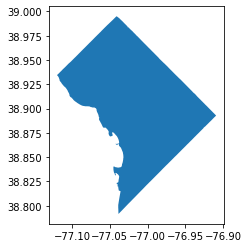

In [ ]:
dc.plot();

Remember, we want to use the geometry on the right to slice into our tract information on the left.

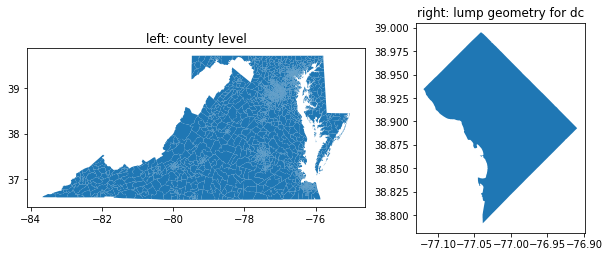

In [ ]:
from matplotlib import gridspec

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_title("left: county level")
tracts.plot(ax=ax0)


ax1 = plt.subplot(gs[1])
ax1.set_title("right: lump geometry for dc")
dc.plot(ax=ax1)

In [ ]:
dc.head()

dummy_col
1    POLYGON ((-77.00128 38.82129, -77.00194 38.820...
Name: geometry, dtype: geometry

In [ ]:
## Needs lots of memory to run!  Won't work in default Colab
# remember, overlay takes two GeoDataFrames as arguments
dc_again = gpd.overlay(tracts, gpd.GeoDataFrame(dc, geometry=dc), how='intersection')

And now we've walked away with:

In [ ]:
dc_again.head()

,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2000,POP00_SQMI,POP2009,POP09_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,OTHER,MULT_RACE,HISPANIC,MALES,FEMALES,AGE_UNDER5,AGE_5_17,AGE_18_21,AGE_22_29,AGE_30_39,AGE_40_49,AGE_50_64,AGE_65_UP,MED_AGE,MED_AGE_M,MED_AGE_F,HOUSEHOLDS,AVE_HH_SZ,HSEHLD_1_M,HSEHLD_1_F,MARHH_CHD,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,...,eEAT_F9G,eEAT_F10G,eEAT_F11G,eEAT_F12N,eEAT_FHSC,eEAT_FCG1,eEAT_FCG1P,eEAT_FASD,eEAT_FBAC,eEAT_FMAS,eEAT_FPRO,eEAT_FDOC,eTPOP,eMALES,eFEMALES,eLABFORCE,eLABMALES,eLABFEMALE,eEMPLOYED,eEMPMALES,eEMPFEMALE,eTAGRFRFSH,eTMINING,eTCONSTR,eTMANUFACT,eTWHOLESAL,eTRETAIL,eTTRANSPUT,eTINFORMAT,eTFINACT,eTPROFBUS,eTEDUHLTH,eTLEISHOSP,eTOTHER,eTPUBADMIN,eTTOTALEMP,eMAGRFRFSH,stname,stusps,geometry
0,11,001,11001,000100,11001000100,4674,5025.8,4825,5186.0,4220,188,9,167,3,25,62,192,2194,2480,159,301,80,770,974,699,1004,687,40.7,40.2,41.1,2724,1.68,623,859,214,555,11,40,881,2.48,...,0,0,0,55,168,25,144,24,669,641,239,198,4983,2352,2631,3610,1792,1814,3573,1777,1796,252,253,253,253,254,254,254,254,255,257,257,257,260,260,3573,125,District of Columbia,DC,"POLYGON ((-77.05947 38.91835, -77.05922 38.918..."
1,11,001,11001,000201,11001000201,4467,23510.5,4450,23368.4,3925,240,0,242,56,2,2,75,2019,2448,4,28,4068,282,24,13,21,27,19.9,19.9,19.8,28,2.79,8,4,1,3,1,2,8,2.75,...,0,0,0,0,565,0,565,0,539,1258,385,0,5523,2581,2942,2822,1310,1511,2794,1304,1490,199,199,199,199,199,199,199,199,200,200,200,200,201,201,2794,93,District of Columbia,DC,"POLYGON ((-77.07289 38.91223, -77.07295 38.911..."
2,11,001,11001,000202,11001000202,3850,8555.6,3987,8826.7,3472,61,3,204,2,34,74,190,1912,1938,146,169,527,863,616,443,721,365,32.9,32.8,33.1,1916,2.00,374,423,159,408,11,27,657,2.49,...,0,0,6,18,73,38,112,35,637,503,116,97,4489,2234,2255,3059,1653,1400,3017,1629,1388,211,212,213,213,215,215,216,217,217,217,217,218,218,218,3017,114,District of Columbia,DC,"POLYGON ((-77.06598 38.91242, -77.06558 38.911..."
3,11,001,11001,000300,11001000300,5706,14630.8,5802,14892.3,4951,175,10,328,2,92,148,324,2649,3057,238,251,399,1887,1244,598,744,345,30.4,30.3,30.5,2784,2.05,445,732,261,506,12,52,933,2.53,...,0,10,0,6,177,29,219,71,1004,777,233,174,6818,3221,3597,4865,2303,2559,4829,2294,2535,341,341,343,344,344,344,345,345,345,346,346,348,348,349,4829,162,District of Columbia,DC,"POLYGON ((-77.07504 38.92254, -77.07468 38.922..."
4,11,001,11001,000400,11001000400,1510,2516.7,1529,2551.7,1284,67,3,89,0,24,43,123,737,773,50,171,47,217,183,190,405,247,45.2,42.1,46.8,649,2.32,98,140,113,201,0,6,347,2.80,...,0,7,0,0,31,6,57,37,221,159,83,43,1579,773,806,1047,593,453,1028,581,447,72,72,72,72,72,72,73,73,73,75,75,75,76,76,1028,41,District of Columbia,DC,"POLYGON ((-77.06637 38.92899, -77.06637 38.927..."


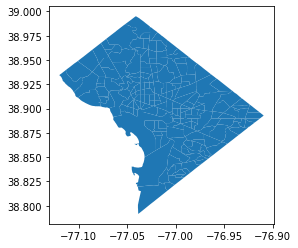

In [ ]:
dc_again.plot();

## Buffering a Point
First, let's get a point to represent Washington DC using the built in national capitols GeoDataFrame.

In [ ]:
import geopandas as gpd
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
washdc = cities[cities['name']=='Washington, D.C.']

In [ ]:
washdc = washdc.to_crs(epsg=2263)
tracts = tracts.to_crs(epsg=2263)
cities = cities.to_crs(epsg=2263)

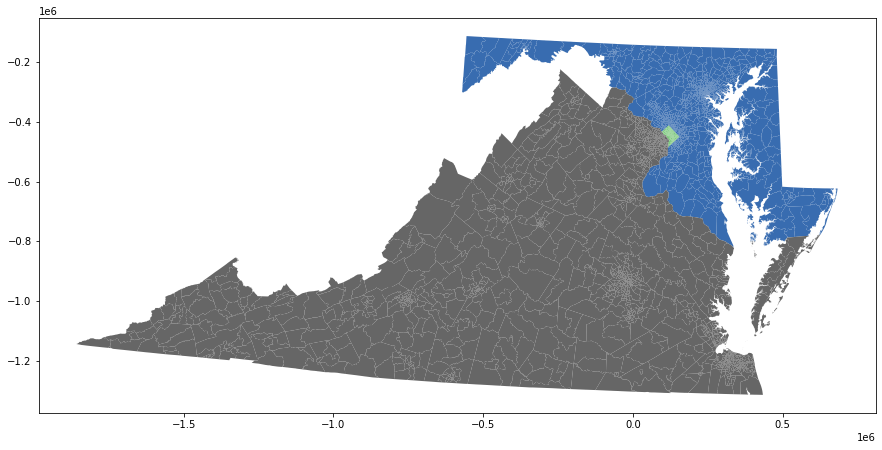

In [ ]:
tracts.plot(figsize=(15,10), column='STATE_FIPS', cmap='Accent');

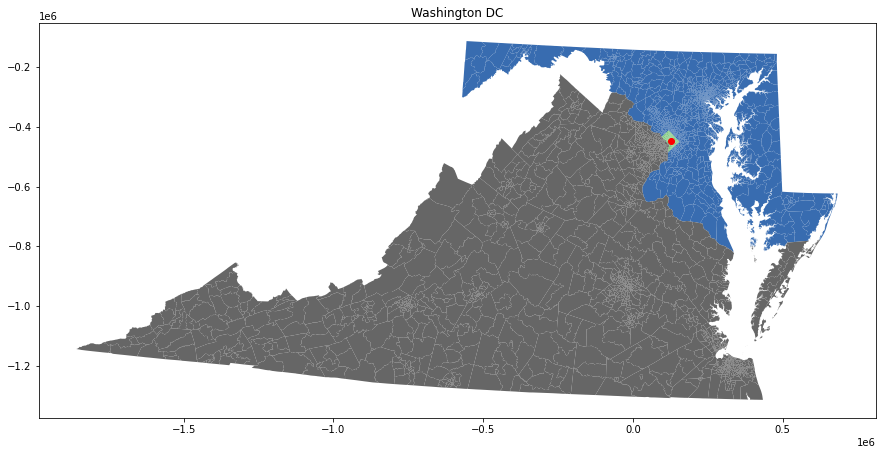

In [ ]:
base = tracts.plot(figsize=(15,10), column='STATE_FIPS', cmap='Accent')
washdc.plot(ax=base, color='red')
plt.title("Washington DC")
plt.show()

In [ ]:
washdc_buff = washdc.buffer(52800) #ten mile buffer (in feet)
washdc_buff

186    POLYGON ((179698.458 -446236.239, 179444.212 -...
dtype: geometry

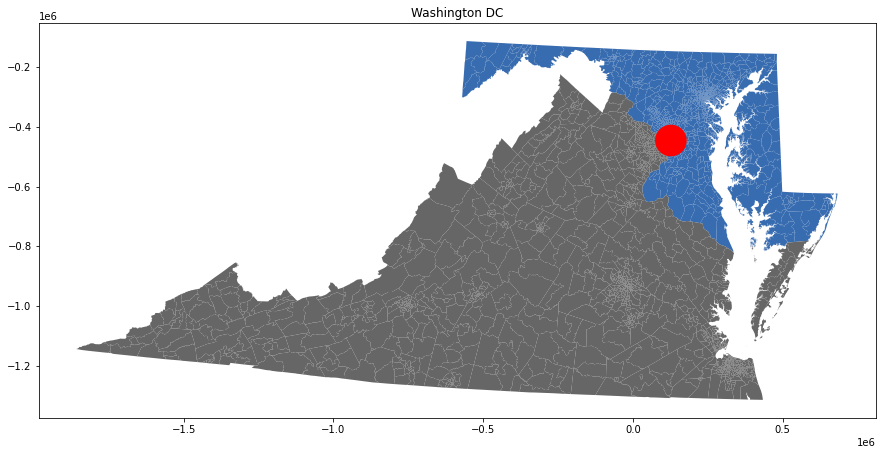

In [ ]:
base = tracts.plot(figsize=(15,10), column='STATE_FIPS', cmap='Accent')
washdc_buff.plot(ax=base, color='red')
plt.title("Washington DC")
plt.show()

Now we can use the `.overlay()` function again to get the _intersection_ of these two shapes.  It's important to note that  `.overlay()` only takes two GeoDataFrames that contain polygons, so we couldn't use it with point data.

In [ ]:
r = gpd.overlay(tracts, gpd.GeoDataFrame(washdc_buff, geometry=washdc_buff), how='intersection')

CPU times: user 1.31 s, sys: 8.45 ms, total: 1.32 s
Wall time: 1.32 s


We can see from our y axis here that yes, indeed, we have all area within ten miles of DC, and have carved out slices of Maryland and Virginia as well.

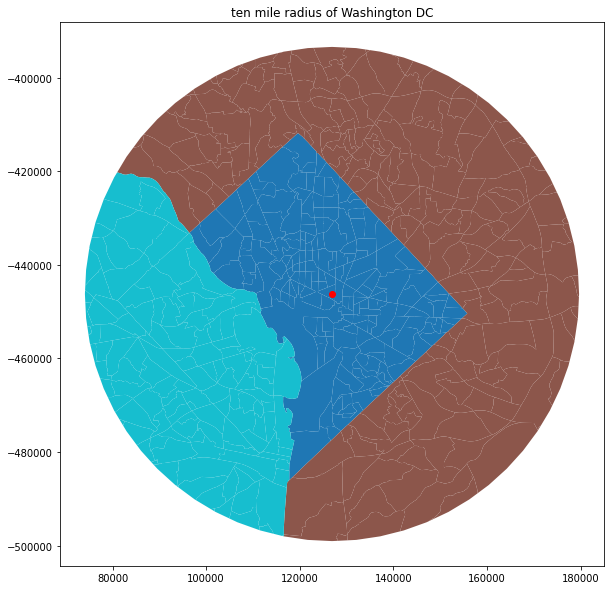

In [ ]:
base = r.plot(figsize=(20,10), column='STATE_FIPS')
cities[cities['name']=='Washington, D.C.'].plot(ax=base, color='red')
plt.title("ten mile radius of Washington DC")
plt.show()

## Unknown Incidents
Let's pull out our DC cencus tracts again. Let's select using our `stusps` code.

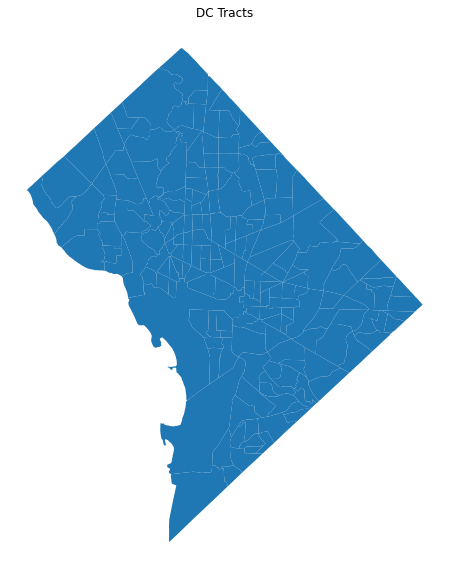

In [ ]:
dc = tracts[tracts['stusps']=='DC']
dc.plot(figsize=(20,10)).set_title("DC Tracts")
plt.axis("off")
plt.show()

Now, let's pull in our csv of mystery incidents and turn it into a GeoDataFrame so we can plot it.

In [ ]:
##connect to an externally hosted file
#response = requests.get('path/to/incidents.csv')
 
    
##download that file
# with open('incidents.csv', 'wb') as fd:
#     for chunk in response.iter_content(chunk_size=128):
#         fd.write(chunk)

In [ ]:
events = pd.read_csv("events.csv", index_col=0)

In [ ]:
z = gpd.GeoDataFrame(data=events, crs=dc.crs, geometry=gpd.points_from_xy(events.LONGITUDE,\
                                                               events.LATITUDE))

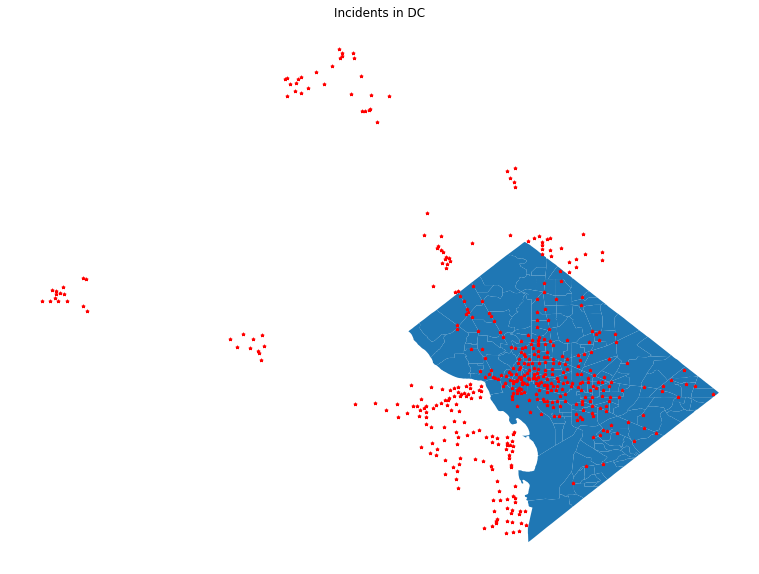

In [ ]:
base = dc.plot(figsize=(20,10))
z.plot(ax=base, marker='*', color='red', markersize=10)
plt.title("Incidents in DC")
plt.axis('off')
plt.show()

In order to select _just_ the points that intersect with DC, we will use the dissolve function again. In our case, we will use it to create one large geometry of DC, and use the method of creating a mask to select our points. Note, it returns a GeoDataFrame, so we must access the geometry the same way we would in any other case.

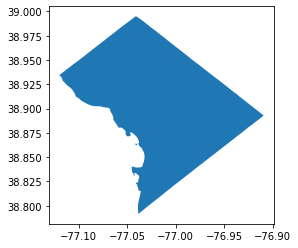

In [ ]:
dc.dissolve(by='STATE_FIPS').plot();

In [ ]:
dc.dissolve(by='STATE_FIPS')

,geometry,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2000,POP00_SQMI,POP2009,POP09_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,OTHER,MULT_RACE,HISPANIC,MALES,FEMALES,AGE_UNDER5,AGE_5_17,AGE_18_21,AGE_22_29,AGE_30_39,AGE_40_49,AGE_50_64,AGE_65_UP,MED_AGE,MED_AGE_M,MED_AGE_F,HOUSEHOLDS,AVE_HH_SZ,HSEHLD_1_M,HSEHLD_1_F,MARHH_CHD,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,...,eEAT_F25P,eEAT_F9G,eEAT_F10G,eEAT_F11G,eEAT_F12N,eEAT_FHSC,eEAT_FCG1,eEAT_FCG1P,eEAT_FASD,eEAT_FBAC,eEAT_FMAS,eEAT_FPRO,eEAT_FDOC,eTPOP,eMALES,eFEMALES,eLABFORCE,eLABMALES,eLABFEMALE,eEMPLOYED,eEMPMALES,eEMPFEMALE,eTAGRFRFSH,eTMINING,eTCONSTR,eTMANUFACT,eTWHOLESAL,eTRETAIL,eTTRANSPUT,eTINFORMAT,eTFINACT,eTPROFBUS,eTEDUHLTH,eTLEISHOSP,eTOTHER,eTPUBADMIN,eTTOTALEMP,eMAGRFRFSH,stname,stusps
STATE_FIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,"POLYGON ((-77.00128 38.82129, -77.00194 38.820...",001,11001,000100,11001000100,4674,5025.8,4825,5186.0,4220,188,9,167,3,25,62,192,2194,2480,159,301,80,770,974,699,1004,687,40.7,40.2,41.1,2724,1.68,623,859,214,555,11,40,881,2.48,...,2181,0,0,0,55,168,25,144,24,669,641,239,198,4983,2352,2631,3610,1792,1814,3573,1777,1796,252,253,253,253,254,254,254,254,255,257,257,257,260,260,3573,125,District of Columbia,DC


In [ ]:
mask = z.within(dc.dissolve(by='STATE_FIPS').geometry[0])

Now, we just "throw away" the points that we don't want.

In [ ]:
z = z[mask]

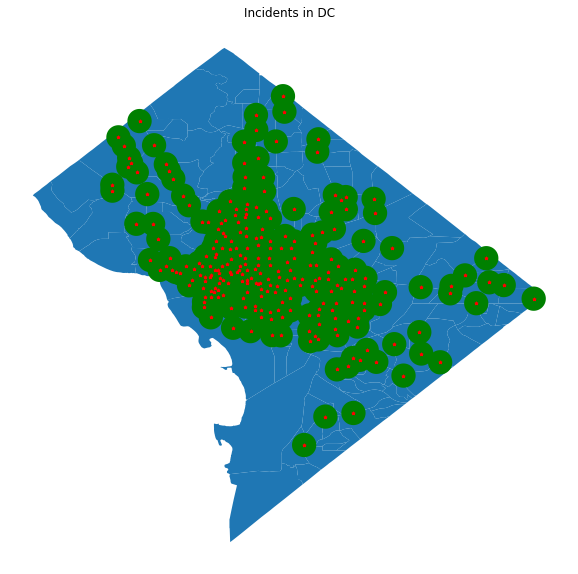

In [ ]:
base= dc.plot(figsize=(20,10))
plt.title("Incidents in DC")
z.buffer(.005).plot(ax=base, color='green')
z.plot(ax=base, marker='*', color='red', markersize=10)
plt.axis("off")
plt.show()

Let's reproject our data into an Equidistant Conic projection.

In [ ]:
eq_conic_proj4 = '+ellps=WGS84 +proj=eqdc +lon_0=-77 +lat_0=38.8 +x_0=0.0 +y_0=0.0 +lat_1=20.0 +lat_2=50.0 +no_defs'
z_eq = z.to_crs(eq_conic_proj4)
dc_eq = dc.to_crs(eq_conic_proj4)

In [ ]:
dc_eq.head()

,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2000,POP00_SQMI,POP2009,POP09_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,OTHER,MULT_RACE,HISPANIC,MALES,FEMALES,AGE_UNDER5,AGE_5_17,AGE_18_21,AGE_22_29,AGE_30_39,AGE_40_49,AGE_50_64,AGE_65_UP,MED_AGE,MED_AGE_M,MED_AGE_F,HOUSEHOLDS,AVE_HH_SZ,HSEHLD_1_M,HSEHLD_1_F,MARHH_CHD,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,...,eEAT_F9G,eEAT_F10G,eEAT_F11G,eEAT_F12N,eEAT_FHSC,eEAT_FCG1,eEAT_FCG1P,eEAT_FASD,eEAT_FBAC,eEAT_FMAS,eEAT_FPRO,eEAT_FDOC,eTPOP,eMALES,eFEMALES,eLABFORCE,eLABMALES,eLABFEMALE,eEMPLOYED,eEMPMALES,eEMPFEMALE,eTAGRFRFSH,eTMINING,eTCONSTR,eTMANUFACT,eTWHOLESAL,eTRETAIL,eTTRANSPUT,eTINFORMAT,eTFINACT,eTPROFBUS,eTEDUHLTH,eTLEISHOSP,eTOTHER,eTPUBADMIN,eTTOTALEMP,eMAGRFRFSH,stname,stusps,geometry
ObjectID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11910,11,001,11001,000100,11001000100,4674,5025.8,4825,5186.0,4220,188,9,167,3,25,62,192,2194,2480,159,301,80,770,974,699,1004,687,40.7,40.2,41.1,2724,1.68,623,859,214,555,11,40,881,2.48,...,0,0,0,55,168,25,144,24,669,641,239,198,4983,2352,2631,3610,1792,1814,3573,1777,1796,252,253,253,253,254,254,254,254,255,257,257,257,260,260,3573,125,District of Columbia,DC,"POLYGON ((-4988.726 13140.168, -4967.418 13139..."
11911,11,001,11001,000201,11001000201,4467,23510.5,4450,23368.4,3925,240,0,242,56,2,2,75,2019,2448,4,28,4068,282,24,13,21,27,19.9,19.9,19.8,28,2.79,8,4,1,3,1,2,8,2.75,...,0,0,0,0,565,0,565,0,539,1258,385,0,5523,2581,2942,2822,1310,1511,2794,1304,1490,199,199,199,199,199,199,199,199,200,200,200,200,201,201,2794,93,District of Columbia,DC,"POLYGON ((-6115.311 12460.614, -6119.735 12372..."
11912,11,001,11001,000202,11001000202,3850,8555.6,3987,8826.7,3472,61,3,204,2,34,74,190,1912,1938,146,169,527,863,616,443,721,365,32.9,32.8,33.1,1916,2.00,374,423,159,408,11,27,657,2.49,...,0,0,6,18,73,38,112,35,637,503,116,97,4489,2234,2255,3059,1653,1400,3017,1629,1388,211,212,213,213,215,215,216,217,217,217,217,218,218,218,3017,114,District of Columbia,DC,"POLYGON ((-5535.510 12481.417, -5501.503 12397..."
11913,11,001,11001,000300,11001000300,5706,14630.8,5802,14892.3,4951,175,10,328,2,92,148,324,2649,3057,238,251,399,1887,1244,598,744,345,30.4,30.3,30.5,2784,2.05,445,732,261,506,12,52,933,2.53,...,0,10,0,6,177,29,219,71,1004,777,233,174,6818,3221,3597,4865,2303,2559,4829,2294,2535,341,341,343,344,344,344,345,345,345,346,346,348,348,349,4829,162,District of Columbia,DC,"POLYGON ((-6294.242 13606.183, -6263.959 13605..."
11914,11,001,11001,000400,11001000400,1510,2516.7,1529,2551.7,1284,67,3,89,0,24,43,123,737,773,50,171,47,217,183,190,405,247,45.2,42.1,46.8,649,2.32,98,140,113,201,0,6,347,2.80,...,0,7,0,0,31,6,57,37,221,159,83,43,1579,773,806,1047,593,453,1028,581,447,72,72,72,72,72,72,73,73,73,75,75,75,76,76,1028,41,District of Columbia,DC,"POLYGON ((-5566.936 14320.830, -5566.961 14155..."


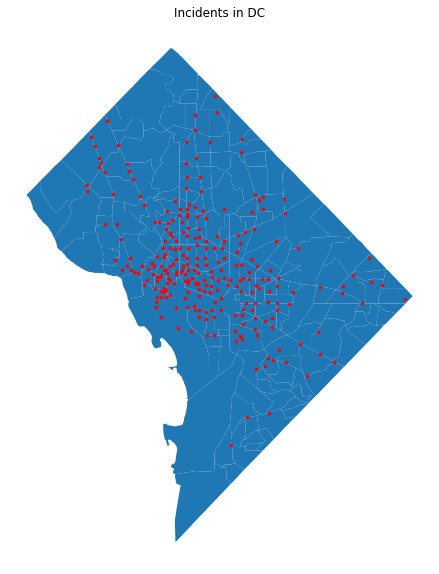

In [ ]:
base= dc_eq.plot(figsize=(20,10))
plt.title("Incidents in DC")
z_eq.plot(ax=base, marker='*', color='red', markersize=10)
plt.axis("off")
plt.show()

In [ ]:
z_buff = z.copy()

In [ ]:
z_buff['buffers']= z.buffer(.005) # this is in dec degrees because we haven't projected points

In [ ]:
z_buff = z_buff.set_geometry('buffers')

We need to _reproject_ again.

In [ ]:
z_buff = z_buff.to_crs(eq_conic_proj4)

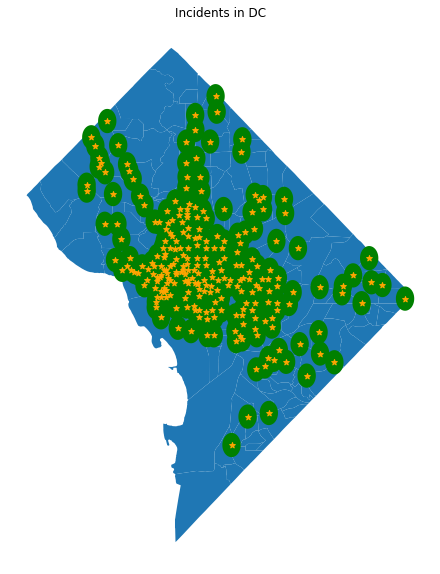

In [ ]:
base= dc_eq.plot(figsize=(20,10))
plt.title("Incidents in DC")
z_buff.plot(ax=base, color='green')
z_eq.plot(ax=base, color='orange', marker="*")
plt.axis("off")
plt.show()

#### Which neighborhoods are close to these events?
Now, we can use a spatial join on our tract polygons and our point buffer polygons to get a GeoDataFrame of tracts that are close to events. As we can see below, it is most of them.

In [ ]:
dangerous = gpd.sjoin(dc_eq,z_buff,op='intersects').drop(columns=['geometry_right'])

In [ ]:
type(dangerous)

pandas.core.frame.DataFrame

In [ ]:
dangerous = gpd.GeoDataFrame(data=dangerous, geometry='geometry_left')

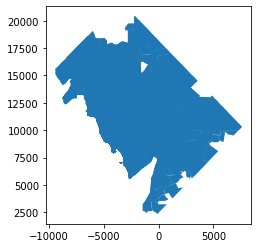

In [ ]:
dangerous.plot();

So, we can see that we ended up with _any_ tract that was touched by a buffer of our events points. Let's assign them all a "dangerous label" by creating a column in this data frame, then merging that column into our complete list of tracts.

In [ ]:
dangerous['near_event'] = 1

In [ ]:
dc_eq = dc_eq.merge(dangerous, how='left')
dc_eq.head()

,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2000,POP00_SQMI,POP2009,POP09_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,OTHER,MULT_RACE,HISPANIC,MALES,FEMALES,AGE_UNDER5,AGE_5_17,AGE_18_21,AGE_22_29,AGE_30_39,AGE_40_49,AGE_50_64,AGE_65_UP,MED_AGE,MED_AGE_M,MED_AGE_F,HOUSEHOLDS,AVE_HH_SZ,HSEHLD_1_M,HSEHLD_1_F,MARHH_CHD,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,...,eEAT_FCG1P,eEAT_FASD,eEAT_FBAC,eEAT_FMAS,eEAT_FPRO,eEAT_FDOC,eTPOP,eMALES,eFEMALES,eLABFORCE,eLABMALES,eLABFEMALE,eEMPLOYED,eEMPMALES,eEMPFEMALE,eTAGRFRFSH,eTMINING,eTCONSTR,eTMANUFACT,eTWHOLESAL,eTRETAIL,eTTRANSPUT,eTINFORMAT,eTFINACT,eTPROFBUS,eTEDUHLTH,eTLEISHOSP,eTOTHER,eTPUBADMIN,eTTOTALEMP,eMAGRFRFSH,stname,stusps,geometry,geometry_left,index_right,LATITUDE,LONGITUDE,INTENSITY,near_event
0,11,001,11001,000100,11001000100,4674,5025.8,4825,5186.0,4220,188,9,167,3,25,62,192,2194,2480,159,301,80,770,974,699,1004,687,40.7,40.2,41.1,2724,1.68,623,859,214,555,11,40,881,2.48,...,144,24,669,641,239,198,4983,2352,2631,3610,1792,1814,3573,1777,1796,252,253,253,253,254,254,254,254,255,257,257,257,260,260,3573,125,District of Columbia,DC,"POLYGON ((-4988.726 13140.168, -4967.418 13139...","POLYGON ((-4988.726 13140.168, -4967.418 13139...",243.0,38.897293,-77.055570,5.0,1.0
1,11,001,11001,000100,11001000100,4674,5025.8,4825,5186.0,4220,188,9,167,3,25,62,192,2194,2480,159,301,80,770,974,699,1004,687,40.7,40.2,41.1,2724,1.68,623,859,214,555,11,40,881,2.48,...,144,24,669,641,239,198,4983,2352,2631,3610,1792,1814,3573,1777,1796,252,253,253,253,254,254,254,254,255,257,257,257,260,260,3573,125,District of Columbia,DC,"POLYGON ((-4988.726 13140.168, -4967.418 13139...","POLYGON ((-4988.726 13140.168, -4967.418 13139...",75.0,38.899500,-77.054155,1.0,1.0
2,11,001,11001,000100,11001000100,4674,5025.8,4825,5186.0,4220,188,9,167,3,25,62,192,2194,2480,159,301,80,770,974,699,1004,687,40.7,40.2,41.1,2724,1.68,623,859,214,555,11,40,881,2.48,...,144,24,669,641,239,198,4983,2352,2631,3610,1792,1814,3573,1777,1796,252,253,253,253,254,254,254,254,255,257,257,257,260,260,3573,125,District of Columbia,DC,"POLYGON ((-4988.726 13140.168, -4967.418 13139...","POLYGON ((-4988.726 13140.168, -4967.418 13139...",238.0,38.902221,-77.059219,11.0,1.0
3,11,001,11001,000100,11001000100,4674,5025.8,4825,5186.0,4220,188,9,167,3,25,62,192,2194,2480,159,301,80,770,974,699,1004,687,40.7,40.2,41.1,2724,1.68,623,859,214,555,11,40,881,2.48,...,144,24,669,641,239,198,4983,2352,2631,3610,1792,1814,3573,1777,1796,252,253,253,253,254,254,254,254,255,257,257,257,260,260,3573,125,District of Columbia,DC,"POLYGON ((-4988.726 13140.168, -4967.418 13139...","POLYGON ((-4988.726 13140.168, -4967.418 13139...",436.0,38.902814,-77.061043,8.0,1.0
4,11,001,11001,000100,11001000100,4674,5025.8,4825,5186.0,4220,188,9,167,3,25,62,192,2194,2480,159,301,80,770,974,699,1004,687,40.7,40.2,41.1,2724,1.68,623,859,214,555,11,40,881,2.48,...,144,24,669,641,239,198,4983,2352,2631,3610,1792,1814,3573,1777,1796,252,253,253,253,254,254,254,254,255,257,257,257,260,260,3573,125,District of Columbia,DC,"POLYGON ((-4988.726 13140.168, -4967.418 13139...","POLYGON ((-4988.726 13140.168, -4967.418 13139...",154.0,38.903663,-77.067668,10.0,1.0


Since any row that was missing a value (any neighborhood _not_ near an incident) got filled with NaN, let's replace those with 0. Finally, we can plot our `dc_eq` shapefile again, differentiating on the `near_event` column to confirm we merged our data back in correctly.

In [ ]:
dc_eq = dc_eq.fillna(value={'near_event':0})

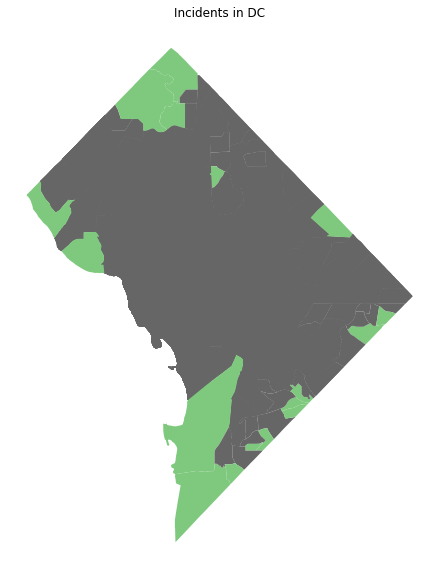

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Incidents in DC")
dc_eq.plot(ax=ax, column="near_event", cmap='Accent')
plt.axis("off")
plt.show()